In [1]:
import numpy as np
import pandas as pd
from scipy.special import binom

In [2]:
import scipy.stats as stats

In [3]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

Generation of the binomial mixture model data.

In [4]:
np.random.seed(42)
n_estimation = 100
n_components = 5
p_values = np.random.rand(n_components)
n_values = np.random.randint(10,50, size=n_components)
true_labels = np.repeat(np.arange(n_components), n_values)
S = np.concatenate([np.random.binomial(n_estimation, p, size=n) for p, n in zip(p_values, n_values)])

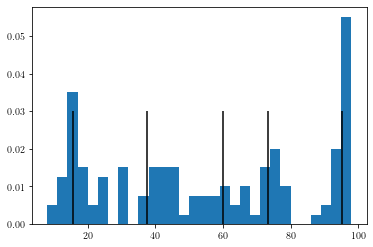

In [5]:
plt.hist(S, bins=30, density=True)
plt.vlines(n_estimation*p_values, ymin=0, ymax=0.03)

In [6]:
def plot_binomial_mixture(p_values, proportions=None, S=None):
    if proportions is None:
        proportions = np.ones_like(p_values)
    fig = go.Figure()
    for p, prop in zip(p_values, proportions):
        x = np.arange(stats.binom.ppf(0.01, n_estimation, p), stats.binom.ppf(0.99, n_estimation, p))
        fig.add_scatter(x=x, y=prop*stats.binom.pmf(x,n_estimation, p), mode="lines", name=f"p={p:.3f}")
    if S is not None:
        fig.add_histogram(x=S, nbinsx=30, histnorm="probability density")
    fig.show()

In [7]:
proportions = n_values/np.sum(n_values)
plot_binomial_mixture(p_values, proportions=proportions, S=S)

In [8]:
from BinomialEM import BinomialEM

In [9]:
bem1 = BinomialEM(n_components=10, n_estimation=n_estimation, max_iter=500)
bem1.fit(S)
bem1.p_

100%|██████████| 500/500 [00:01<00:00, 464.26it/s]


array([0.15462279, 0.15462279, 0.28391218, 0.42125118, 0.42125118,
       0.58750466, 0.73681867, 0.73681867, 0.88782851, 0.95125157])

In [16]:
bem1.save("test_save.pkl")
del bem1
bem1 = BinomialEM()
bem1.load("test_save.pkl")
bem1

In [18]:
bem1.predict(S)

array([3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 2, 3, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 7, 7, 7, 7, 7, 7,
       7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 3, 5, 5, 5, 5, 5, 7, 5, 5, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2], dtype=int64)

When two binomial models in th mixture are too similar, the EM algorithm will not separate them properly, therefore a solution is too first overestimate the number of components of the mixture so it can capture little differences in the data. And then only get the unique values obtained after the first run of the algorithm to initialize the second run of the EM algorithm.

In [17]:
first_p = np.unique(np.around(bem1.p_,6))
first_p

array([0.154623, 0.283912, 0.421251, 0.587505, 0.736819, 0.887829,
       0.951252])

In [11]:
bem2 = BinomialEM(n_components=first_p.shape[0], n_estimation=n_estimation)
bem2.fit(S, initial_p=first_p)

100%|██████████| 100/100 [00:00<00:00, 357.10it/s]


In [12]:
proportions = bem2.lambd_
plot_binomial_mixture(bem2.p_, proportions=proportions, S=S)

In [13]:
bem2.p_

array([0.15462279, 0.28391218, 0.42125118, 0.58750466, 0.73681867,
       0.88782851, 0.95125157])

In [14]:
np.sort(p_values)

array([0.15601864, 0.37454012, 0.59865848, 0.73199394, 0.95071431])

In [15]:
df = pd.DataFrame(S, columns=["S"])

In [16]:
df["true_labels"] = true_labels
df["predicted_labels"] = bem2.predict(S)
df.head()

,S,true_labels,predicted_labels
0,42,0,2
1,38,0,2
2,30,0,1
3,37,0,2
4,31,0,1


In [17]:
px.histogram(df, x="S", color="true_labels", barmode="overlay", nbins=30)

In [18]:
px.histogram(df, x="S", color="predicted_labels", barmode="overlay", nbins=30)